In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as img
import torch

import torchvision.transforms as transforms
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import torch.nn.functional as F
from torchvision import models
from torchvision.models import ResNet18_Weights
import torchvision.models as models

In [2]:
easy_images_df = pd.read_parquet('easy-500/images.parquet')
easy_labels_df = pd.read_parquet('easy-500/labels.parquet')

In [3]:
easy_labels_df.head()

,image_id,x,y,orientation,radius,class
0,0,269,450,0.000000,17,0
1,0,533,299,0.663225,45,1
2,0,539,427,0.610865,46,1
3,0,365,148,0.488692,45,1
4,0,472,136,2.426008,40,1


In [4]:
easy_images_df.head()

,id,image
0,0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
1,1,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
2,2,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
3,3,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
4,4,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...


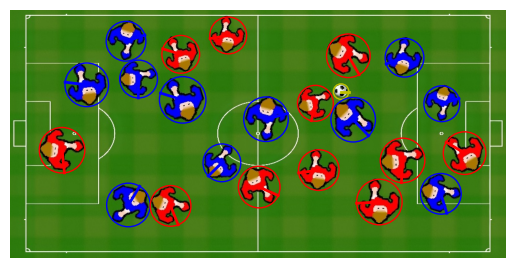

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image


# Load the image
image_path = 'images/4.jpg'
image = Image.open(image_path)

# Define a function to plot labels with different colors for different classes
def plot_labels_on_image(image, labels_df):
    plt.imshow(image)

    # Define colors for different classes
    class_colors = ['y', 'b', 'r']

    # Plot the labels
    for index, row in labels_df.iterrows():
        x, y = row['x'], row['y']
        radius = row['radius']
        orientation = row['orientation']
        class_id = row['class']

        # Calculate the end point of the orientation line
        end_x = x + radius * np.cos(orientation)
        end_y = y + radius * np.sin(orientation)

        # Plot the orientation line
        plt.plot([x, end_x], [y, end_y], color=class_colors[int(class_id)], linewidth=2)

        # Plot the object circle
        circle = patches.Circle((x, y), radius, edgecolor=class_colors[int(class_id)], facecolor='none')
        plt.gca().add_patch(circle)

    plt.axis('off')
    plt.show()


# Filter the labels DataFrame for a specific image ID
image_id = 4
filtered_labels_df = easy_labels_df[easy_labels_df['image_id'] == image_id]

# Plot the image with labels
plot_labels_on_image(image, filtered_labels_df)


In [6]:
labels_df = easy_labels_df
labels_df.shape

(11500, 6)

In [7]:
labels_df = labels_df.drop('orientation',axis =1)
labels_df['width'] = labels_df['radius'] *2
labels_df['height'] = labels_df['radius'] *2
labels_df['classes'] = labels_df['class']
labels_df = labels_df.drop('class', axis=1)
labels_df = labels_df.drop('radius', axis=1)

In [8]:
labels_df.head()

,image_id,x,y,width,height,classes
0,0,269,450,34,34,0
1,0,533,299,90,90,1
2,0,539,427,92,92,1
3,0,365,148,90,90,1
4,0,472,136,80,80,1


In [9]:
labels_limit = labels_df['image_id'].nunique()
labels_limit

500

In [10]:
processed_images = []
processed_annotations = []
adjusted_values_final = []

img_dir = 'images'
img_size = 448
S = 7
C = 3

from PIL import ImageOps

for i in range(labels_limit):
        target_annotation = np.zeros((S, S, 5 + C))     
        # Load and resize the image
        from PIL import Image, ImageOps

        # Load the original image
        image_path = os.path.join(img_dir, f"{int(i)}.jpg")
        image = Image.open(image_path)
        original_width, original_height = image.size

        # Resize while preserving aspect ratio
        desired_size = img_size
        old_size = image.size
        ratio = float(desired_size) / max(old_size)
        new_size = tuple([int(x * ratio) for x in old_size])
        image = image.resize(new_size)

        # Pad the resized image to fit the desired size
        delta_w = desired_size - new_size[0]
        delta_h = desired_size - new_size[1]
        padding = (delta_w // 2, delta_h // 2, delta_w - (delta_w // 2), delta_h - (delta_h // 2))
        image = ImageOps.expand(image, padding, fill=0)

        # Convert image to numpy array
        image_array = np.array(image)
        # Normalize the image
        image_array = image_array / 255.0



        # Adjust annotation values
        x_ratio = img_size / original_width
        y_ratio = img_size / original_height

        for _,row in labels_df[labels_df['image_id'] == i].iterrows():
                x, y, width, height, class_label = row[1:]
                adjusted_x = x * x_ratio
                adjusted_y = y * y_ratio
                adjusted_width = width * x_ratio
                adjusted_height = height * y_ratio
                adjusted_values_final.append((i,adjusted_x,adjusted_y,adjusted_width,adjusted_height, class_label))
                
                # Convert coordinates to grid cell format
                grid_x = int(adjusted_x // (img_size // S))
                grid_y = int(adjusted_y // (img_size // S))
                cell_x = (adjusted_x % (img_size // S)) / (img_size // S)
                cell_y = (adjusted_y % (img_size // S)) / (img_size // S)
                cell_width = adjusted_width / (img_size / S)
                cell_height = adjusted_height / (img_size / S)

                # Create target annotation tensor
                target_annotation[grid_y, grid_x, 0:4] = [cell_x, cell_y, cell_width, cell_height]
                target_annotation[grid_y, grid_x, 4] = 1
                target_annotation[grid_y, grid_x, 5 + int(class_label)] = 1
        
        processed_images.append(image_array)
        processed_annotations.append(target_annotation)
   
processed_images = np.array(processed_images)
processed_annotations = np.array(processed_annotations)
adjusted_values_final = np.array(adjusted_values_final)

# Print the shapes of the processed data
print("Processed Images Shape:", processed_images.shape)
print("Processed Annotations Shape:", processed_annotations.shape)
adjusted_values_final.shape

Processed Images Shape: (500, 448, 448, 3)
Processed Annotations Shape: (500, 7, 7, 8)


(11500, 6)

In [11]:
processed_annotations[1]

array([[[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        ],
        [0.45214844, 0.91601562, 0.6015625 , 1.203125  , 1.        ,
         0.        , 1.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        ]],

       [[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         

In [12]:
class YoloDataset(Dataset):
    def __init__(self, images, annotations):
        self.images = images
        self.annotations = annotations
        self.transform = transforms.Compose([transforms.ToTensor()])

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        image = self.transform(image)
        
        annotation = self.annotations[idx]
        return {'images' : image, 'annotations' : annotation}
    
dataset = YoloDataset(processed_images, processed_annotations)
dataloader = DataLoader(dataset, batch_size=16)

for batch in dataloader:
    images, annotations = batch['images'], batch['annotations']
    print(images.shape)
    print(annotations.shape)

torch.Size([16, 3, 448, 448])
torch.Size([16, 7, 7, 8])
torch.Size([16, 3, 448, 448])
torch.Size([16, 7, 7, 8])
torch.Size([16, 3, 448, 448])
torch.Size([16, 7, 7, 8])
torch.Size([16, 3, 448, 448])
torch.Size([16, 7, 7, 8])
torch.Size([16, 3, 448, 448])
torch.Size([16, 7, 7, 8])
torch.Size([16, 3, 448, 448])
torch.Size([16, 7, 7, 8])
torch.Size([16, 3, 448, 448])
torch.Size([16, 7, 7, 8])
torch.Size([16, 3, 448, 448])
torch.Size([16, 7, 7, 8])
torch.Size([16, 3, 448, 448])
torch.Size([16, 7, 7, 8])
torch.Size([16, 3, 448, 448])
torch.Size([16, 7, 7, 8])
torch.Size([16, 3, 448, 448])
torch.Size([16, 7, 7, 8])
torch.Size([16, 3, 448, 448])
torch.Size([16, 7, 7, 8])
torch.Size([16, 3, 448, 448])
torch.Size([16, 7, 7, 8])
torch.Size([16, 3, 448, 448])
torch.Size([16, 7, 7, 8])
torch.Size([16, 3, 448, 448])
torch.Size([16, 7, 7, 8])
torch.Size([16, 3, 448, 448])
torch.Size([16, 7, 7, 8])
torch.Size([16, 3, 448, 448])
torch.Size([16, 7, 7, 8])
torch.Size([16, 3, 448, 448])
torch.Size([16, 7,

In [13]:
class SimplifiedYOLOv1(nn.Module):
    def __init__(self, num_classes, num_cells=7):
        super(SimplifiedYOLOv1, self).__init__()
        
        # Load pre-trained feature extractor
        resnet18 = models.resnet18(pretrained=True)
        resnet18.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        resnet18 = resnet18.to(torch.float32)  # Convert the entire model to use torch.float32
        
        self.feature_extractor = nn.Sequential(*list(resnet18.children())[:-2])
        self.num_cells = num_cells
        self.num_classes = num_classes
        
        # Calculate the total number of features in the output tensor from the feature extractor
        with torch.no_grad():
            dummy_input = torch.randn(1, 3, 448, 448).to(torch.float32)
            features = self.feature_extractor(dummy_input)
            num_features = features.view(features.size(0), -1).shape[1]

        self.yolo_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_cells * num_cells * (5 + num_classes))
        )

    def forward(self, x):
        features = self.feature_extractor(x)
        predictions = self.yolo_layers(features)
        predictions = predictions.view(-1, self.num_cells, self.num_cells, 5 + self.num_classes)
        return predictions

# Define the rest of your training loop and other parts of the code as before...

def yolo_loss(predictions, targets, bbox_loss_rate=1.0, class_loss_rate=3.0, rotation_loss_rate=1.0, radius_loss_rate=1.0):
    batch_size = predictions.size(0)
    num_cells = predictions.size(1)
    num_classes = predictions.size(3) - 5

    # Unpack predictions and targets
    bbox_pred = predictions[:, :, :, :5]  # x, y, rotation, radius, confidence
    class_pred = predictions[:, :, :, 5:]  # Class probabilities

    bbox_target = targets[:, :, :, :5]  # x, y, rotation, radius, confidence
    class_target = targets[:, :, :, 5:]  # Class labels (one-hot encoded)

    # Bounding box loss
    bbox_loss = F.mse_loss(bbox_pred[:, :, :, :4], bbox_target[:, :, :, :4], reduction='sum') / (batch_size * num_cells * num_cells)  # x, y, radius, orintation
    confidence_loss = F.mse_loss(bbox_pred[:, :, :, 4], bbox_target[:, :, :, 4], reduction='sum') / (batch_size * num_cells * num_cells)  # confidence
    bbox_loss = bbox_loss_rate * (bbox_loss + confidence_loss)

    # Classification loss
    class_loss = F.cross_entropy(class_pred.contiguous().view(-1, num_classes), class_target.contiguous().view(-1, num_classes).argmax(dim=-1), reduction='sum') / (batch_size * num_cells * num_cells)
    class_loss = class_loss_rate * class_loss

    return bbox_loss + class_loss


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
import torch

# Check if GPU is available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define your SimplifiedYOLOv1 model here...

# Training loop
num_classes = 3
num_cells = 7
model = SimplifiedYOLOv1(num_classes=num_classes, num_cells=num_cells).to(device)

# Ensure all model parameters are of type torch.float32
for param in model.parameters():
    param.data = param.data.to(torch.float32)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 10
for epoch in range(num_epochs):
    total_loss = 0.
    i = 0
    for images, targets in dataloader:
        
        images, targets = batch['images'], batch['annotations']
        
        # Ensure input tensors are in torch.float32 data type
        images = images.to(device, dtype=torch.float32)
        targets = targets.to(device, dtype=torch.float32)
        
        optimizer.zero_grad()
        predictions = model(images)
        loss = yolo_loss(predictions, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss
        i += 1
        #if i% 100 == 0:
            #print(f"batch {i} loss: {loss}")
    total_loss = total_loss / len(dataloader)
    print(f"epoch {epoch} loss: {total_loss:6f}")


/Users/beesamprajveenkumar/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/beesamprajveenkumar/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch 0 loss: 6.609488
epoch 1 loss: 4.763423
epoch 2 loss: 4.727334
epoch 3 loss: 4.734204
epoch 4 loss: 4.753190
epoch 5 loss: 4.736572
epoch 6 loss: 4.719981
epoch 7 loss: 4.703448
epoch 8 loss: 4.686992
epoch 9 loss: 4.670620


In [20]:
predictions.shape

torch.Size([1, 7, 7, 8])

In [21]:
# Save model's state_dict
torch.save(model.state_dict(), 'model.pth')

In [22]:
# Load saved weights
eval_model = torch.load('model.pth')
model.load_state_dict(eval_model)
model.eval()


SimplifiedYOLOv1(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_

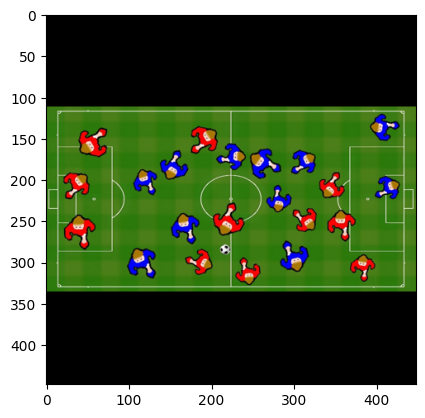

In [30]:
def preprocess_image(image_paths, img_size):
    # Ensure image_paths is a list
    if not isinstance(image_paths, list):
        image_paths = [image_paths]

    image_tensors = []  # Initialize list to store preprocessed image tensors

    # Preprocess each image
    for image_path in image_paths:
        # Load the original image
        image = Image.open(image_path)
        original_width, original_height = image.size

        # Resize while preserving aspect ratio
        desired_size = img_size
        old_size = image.size
        ratio = float(desired_size) / max(old_size)
        new_size = tuple([int(x * ratio) for x in old_size])
        image = image.resize(new_size)

        # Pad the resized image to fit the desired size
        delta_w = desired_size - new_size[0]
        delta_h = desired_size - new_size[1]
        padding = (delta_w // 2, delta_h // 2, delta_w - (delta_w // 2), delta_h - (delta_h // 2))
        image = ImageOps.expand(image, padding, fill=0)

        # Convert image to numpy array and normalize
        image_array = np.array(image) / 255.0

        # Convert numpy array to PyTorch tensor
        image_tensor = torch.tensor(image_array).permute(2, 0, 1).unsqueeze(0).float()

        image_tensors.append(image_tensor)  # Add preprocessed image tensor to the list

    if len(image_tensors) == 1:  # If only one image was preprocessed
        return image_tensors[0]  # Return the single image tensor
    else:
        return image_tensors  # Return the list of image tensors

def visualize_circle_predictions(image_tensor, predictions, threshold=0.1):
    for i in range(image_tensor.shape[0]):
        # Convert image tensor to numpy array
        image = image_tensor[i].permute(1, 2, 0).numpy()

        # Get image dimensions
        img_height, img_width, _ = image.shape

        # Create figure and axes
        fig, ax = plt.subplots(1)
        ax.imshow(image)

        # Iterate over the predictions for the current image
        for j in range(predictions.shape[1]):
            for k in range(predictions.shape[2]):
                # Extract prediction values for the current cell
                cell_data = predictions[i, j, k]
                x, y, w, h, confidence, *class_probs = cell_data[:8]

                # Convert one-hot encoded class probabilities to class index
                class_id = class_probs.index(max(class_probs))

                # Check if confidence score is above the threshold
                if confidence > threshold:
                    # Convert coordinates to image dimensions
                    x *= img_width
                    y *= img_height
                    w *= img_width
                    h *= img_height

                    # Calculate coordinates for drawing the circle
                    center_x = x
                    center_y = y
                    radius = max(w, h) / 2  # Calculate radius from max of width and height

                    # Draw circle
                    circle = patches.Circle((center_x, center_y), radius, linewidth=1, edgecolor='red', facecolor='none')
                    ax.add_patch(circle)

                    # Add class label
                    class_label = f'Class: {class_id}'
                    #ax.text(center_x, center_y, class_label, backgroundcolor='red', fontsize=8, color='white')

        plt.show()


# Example usage
image_paths = ['/Users/beesamprajveenkumar/Documents/Projects/MLX/mlx-week4/easy-500/images/19.jpg']  # Paths to your images
image_tensor = preprocess_image(image_paths, img_size)

# Make predictions using the loaded model
with torch.no_grad():
    predictions = model(image_tensor)

# Visualize the predictions
visualize_circle_predictions(image_tensor, predictions)
